In [1]:
import csv
import pandas as pd
import itertools

In [2]:
data = pd.read_csv('C:\\vscodestation\\jupyter\\wine\\winemag-data-130k-v2.csv', index_col=0)

In [3]:
data.head(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## 1.对数据集进行处理，转换成适合进行关联规则挖掘的形式

### 对于原始数据集，首先删除对频繁模式和关联规则没有意义的列和冗余的列：‘description’，‘taster_twitter_handle’，‘title’

In [4]:
data = data.drop(['description', 'taster_twitter_handle', 'title'], axis=1)

### 处理缺失值

In [5]:
data = data.dropna()

### 去除每一列频率小于1%的记录

In [6]:
for attr in data:
    n = len(data)
    data = data[data.groupby(attr)[attr].transform('count').ge(0.01*n)]

### 对数值属性‘points’和‘price’进行离散化处理和概念分层

In [7]:
print('max: ',data['points'].max())
print('min: ',data['points'].min())

max:  94
min:  82


### 'points'分布于82-94之间，划分为四个层次：
### [82, 86]: bad,  (86, 90]: normal，(90, 94]: good

In [8]:
data['points'] = pd.cut(data['points'], [81, 86, 90, 94], labels=['bad', 'normal', 'good'])

In [9]:
print('max: ',data['price'].max())
print('min: ',data['price'].min())

max:  55.0
min:  14.0


### ‘price’分布于14-55之间，划分为四个层次：
### [14, 24]:low，(24, 34]:general，(34, 44]:high，(44, 55]:highest

In [10]:
data['price'] = pd.cut(data['price'], [13, 24, 34, 44, 55], labels=['low', 'general', 'high', 'highest'])

### 查看数据

In [11]:
data.head(5)

,country,designation,points,price,province,region_1,region_2,taster_name,variety,winery
260,US,Estate,normal,high,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Pinot Noir,Willamette Valley Vineyards
1939,US,Reserve,normal,low,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,Chardonnay,Waterbrook
2557,US,Estate,normal,low,California,Santa Clara Valley,Central Coast,Matt Kettmann,Merlot,Jason-Stephens
2568,US,Estate Grown,normal,general,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,Malbec,Gamache
4887,US,Estate,normal,general,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Chardonnay,Willamette Valley Vineyards


## 2.找出频繁模式并计算其支持度

### 使用apriori算法挖掘频繁模式，由于该数据集本身就存在相关关系，且分析同一属性下的数据频繁模式过于繁杂，没有意义，比如分析'price'属性下的'high'和'low'的频繁模式不能说明任何问题，且算力不够。因此在这里将数据集分为10项集，对应10个属性，利用apriori算法逐项找出频繁模式

### 定义最小支持度

In [12]:
min_support = 0.3

### 定义过滤函数，同时计算其支持度

In [13]:
def frequn_patt(data, Ck, min_support):
    # 计算Ck各项元素的支持度
    subset_support = {}
    for _, row in data.iterrows():
        for ele in Ck:
            if ele.issubset(row):
                subset_support[ele] = subset_support.get(ele, 0) + 1
                
    records_num = len(data)
    ret_list = []
    support_data = {}
    for subset in subset_support:
        support = subset_support[subset]/records_num
        if support >= min_support:
            ret_list.insert(0, subset)
        support_data[subset] = support
    return ret_list, support_data

### 计算1项集

In [14]:
C1 = []
for _, col in data.iteritems():
    for item in col:
        if not [item] in C1:
            C1.append([item])

C1 = list(map(frozenset, C1))

### 计算其支持度

In [15]:
L1, support_data = frequn_patt(data, C1, min_support)

### 显示1项集的支持度

In [16]:
support_data

{frozenset({'US'}): 1.0,
 frozenset({'Estate'}): 0.5688622754491018,
 frozenset({'normal'}): 0.7065868263473054,
 frozenset({'high'}): 0.03592814371257485,
 frozenset({'Oregon'}): 0.2155688622754491,
 frozenset({'Willamette Valley'}): 0.2155688622754491,
 frozenset({'Paul Gregutt'}): 0.39520958083832336,
 frozenset({'Pinot Noir'}): 0.07784431137724551,
 frozenset({'Willamette Valley Vineyards'}): 0.08383233532934131,
 frozenset({'Reserve'}): 0.31137724550898205,
 frozenset({'low'}): 0.47904191616766467,
 frozenset({'Washington'}): 0.3712574850299401,
 frozenset({'Columbia Valley (WA)'}): 0.31736526946107785,
 frozenset({'Columbia Valley'}): 0.3712574850299401,
 frozenset({'Sean P. Sullivan'}): 0.19161676646706588,
 frozenset({'Chardonnay'}): 0.11976047904191617,
 frozenset({'Waterbrook'}): 0.10179640718562874,
 frozenset({'California'}): 0.2874251497005988,
 frozenset({'Santa Clara Valley'}): 0.08383233532934131,
 frozenset({'Central Coast'}): 0.08383233532934131,
 frozenset({'Matt Ket

### 大于0.3支持度的1项集如下

In [17]:
L1

[frozenset({'general'}),
 frozenset({'Columbia Valley'}),
 frozenset({'Columbia Valley (WA)'}),
 frozenset({'Washington'}),
 frozenset({'low'}),
 frozenset({'Reserve'}),
 frozenset({'Paul Gregutt'}),
 frozenset({'normal'}),
 frozenset({'Estate'}),
 frozenset({'US'})]

### 连接计算至10项集

In [18]:
type(data.columns[0])

str

In [19]:
attrs = []
for _, col in data.iteritems():
    attrs.append(_)

In [20]:
support_all = [support_data]
L = [L1]

for k in range(2, 11):
    # 组合
    for cobs in itertools.combinations(attrs, k):
        Ck = []
        # 迭代行
        for i, _ in data.iterrows():
            temp = []
            # 选择列组合的数据加入
            for col in cobs:
                temp.append(data[col][i])
            if temp not in Ck:
                Ck.append(temp)
                
        Ck = list(map(frozenset, Ck))
        Lk, support_data = frequn_patt(data, Ck, min_support)
        if len(Lk) > 0:
            L.append(Lk)
        support_all.append(support_data)

### 显示所有大于0.3的频繁模式如下

In [21]:
L

[[frozenset({'general'}),
  frozenset({'Columbia Valley'}),
  frozenset({'Columbia Valley (WA)'}),
  frozenset({'Washington'}),
  frozenset({'low'}),
  frozenset({'Reserve'}),
  frozenset({'Paul Gregutt'}),
  frozenset({'normal'}),
  frozenset({'Estate'}),
  frozenset({'US'})],
 [frozenset({'Reserve', 'US'}), frozenset({'Estate', 'US'})],
 [frozenset({'US', 'normal'})],
 [frozenset({'US', 'general'}), frozenset({'US', 'low'})],
 [frozenset({'US', 'Washington'})],
 [frozenset({'Columbia Valley (WA)', 'US'})],
 [frozenset({'Columbia Valley', 'US'})],
 [frozenset({'Paul Gregutt', 'US'})],
 [frozenset({'Estate', 'normal'})],
 [frozenset({'general', 'normal'}), frozenset({'low', 'normal'})],
 [frozenset({'Columbia Valley (WA)', 'Washington'})],
 [frozenset({'Columbia Valley', 'Washington'})],
 [frozenset({'Columbia Valley', 'Columbia Valley (WA)'})],
 [frozenset({'Estate', 'US', 'normal'})],
 [frozenset({'US', 'general', 'normal'}), frozenset({'US', 'low', 'normal'})],
 [frozenset({'Columbi

## 3.导出关联规则，计算其支持度和置信度，利用Lift和卡方进行评价，分析挖掘结果

#### 首先定义一个可视化函数和一个可复用计算Lift和卡方评估的函数

In [22]:
from prettytable import PrettyTable
def visual(att1, att2, key1, key2, table, e_table, num):
    un_key1 = '非'+key1
    un_key2 = '非'+key2
    for i in range(4):
        table[i] = round(table[i])
        e_table[i] = round(e_table[i])
    x = PrettyTable(['卡方', key1, un_key1, att1])
    x.add_row([key2, str(table[0])+'('+str(e_table[0])+')', str(table[2])+'('+str(e_table[2])+')', table[0]+table[2]])
    x.add_row([un_key2, str(table[1])+'('+str(e_table[1])+')', str(table[3])+'('+str(e_table[3])+')', table[1]+table[3]])
    x.add_row([att2, table[0]+table[2], table[1]+table[3], num])
    print(x)

In [23]:
def val(att1, att2, key1, key2, s1, s2, comb, num, vis=True, p=True):
    lift = comb/(s1*s2)
    table = [num*comb, num*(s2-comb), num*(s1-comb)]
    last = num
    for n in table:
        last -= n
    table.append(last)
    e_table = [num*s1*s2, num*s2*(1-s1), num*s1*(1-s2)]
    last = num
    for n in e_table:
        last -= n
    e_table.append(last)
    if vis:
        visual(att1, att2, key1, key2, table, e_table, num)
    x = 0
    for i in range(4):
        x += (table[i]-e_table[i])**2/e_table[i]
    if p:
        print('Lift： {:.3f}'.format(lift))
        print('卡方： {:.3f}'.format(x))
    else:
        return lift, x

### 重点观察有相关信息的属性之间的关联规则，比如'points'和'price'之间，分点展开如下

### 3.1 points与price

### points的支持度

In [24]:
for item in support_all[0]:
    if item == {'bad'} or item =={'normal'} or item == {'good'}:
        print(item, support_all[0][item])

frozenset({'normal'}) 0.7065868263473054
frozenset({'good'}) 0.1437125748502994
frozenset({'bad'}) 0.1497005988023952


### price的支持度

In [25]:
for item in support_all[0]:
    if item == {'low'} or item =={'general'} or item == {'high'} or item == {'highest'}:
        print(item, support_all[0][item])

frozenset({'high'}) 0.03592814371257485
frozenset({'low'}) 0.47904191616766467
frozenset({'general'}) 0.437125748502994
frozenset({'highest'}) 0.04790419161676647


### 联合分布的支持度

In [26]:
support_all[18]

{frozenset({'high', 'normal'}): 0.023952095808383235,
 frozenset({'low', 'normal'}): 0.32335329341317365,
 frozenset({'general', 'normal'}): 0.3473053892215569,
 frozenset({'good', 'highest'}): 0.03592814371257485,
 frozenset({'general', 'good'}): 0.03592814371257485,
 frozenset({'bad', 'low'}): 0.08982035928143713,
 frozenset({'bad', 'general'}): 0.05389221556886228,
 frozenset({'good', 'low'}): 0.0658682634730539,
 frozenset({'highest', 'normal'}): 0.011976047904191617,
 frozenset({'bad', 'high'}): 0.005988023952095809,
 frozenset({'good', 'high'}): 0.005988023952095809}

### 关联规则1： points为bad，price为low，置信度如下

In [27]:
conf1 = support_all[18][frozenset({'bad', 'low'})]/support_all[0][frozenset({'bad'})]
print('置信度： {:.3f}'.format(conf1))

置信度： 0.600


### 使用Lift和卡方进行评估

In [28]:
s1 = support_all[0][frozenset({'bad'})]
s2 = support_all[0][frozenset({'low'})]
comb = support_all[18][frozenset({'bad', 'low'})]
val('points', 'price', 'bad', 'low', s1, s2, comb, len(data))

+-------+--------+--------+--------+
|  卡方 |  bad   | 非bad  | points |
+-------+--------+--------+--------+
|  low  | 15(12) | 10(13) |   25   |
| 非low | 65(68) | 77(74) |  142   |
| price |   25   |  142   |  167   |
+-------+--------+--------+--------+
Lift： 1.252
卡方： 1.696


### 分析结果：可以看到Lift结果显示评分低和售价低成正相关，同时卡方检验显示期望值12低于实际值15，也为正相关，因此，我们可以说红酒的评分低可以引起其售价相对较低

### 3.2 points与designation

### designation选择出现较多的Estate进行分析

### Estate和points的支持度

In [29]:
for item in support_all[0]:
    if item == {'Estate'}:
        print(item, support_all[0][item])

frozenset({'Estate'}) 0.5688622754491018


In [30]:
for item in support_all[0]:
    if item == {'bad'} or item =={'normal'} or item == {'good'}:
        print(item, support_all[0][item])

frozenset({'normal'}) 0.7065868263473054
frozenset({'good'}) 0.1437125748502994
frozenset({'bad'}) 0.1497005988023952


### 联合分布的支持度

In [31]:
support_all[10]

{frozenset({'Estate', 'normal'}): 0.38922155688622756,
 frozenset({'Reserve', 'normal'}): 0.23952095808383234,
 frozenset({'Estate Grown', 'normal'}): 0.023952095808383235,
 frozenset({'Reserve', 'good'}): 0.04790419161676647,
 frozenset({'Estate', 'good'}): 0.08982035928143713,
 frozenset({'Estate', 'bad'}): 0.08982035928143713,
 frozenset({'Dry', 'normal'}): 0.05389221556886228,
 frozenset({'Estate Grown', 'bad'}): 0.029940119760479042,
 frozenset({'Reserve', 'bad'}): 0.023952095808383235,
 frozenset({'Dry', 'good'}): 0.005988023952095809,
 frozenset({'Dry', 'bad'}): 0.005988023952095809}

### 关联规则2： designation为Estate，points为normal，置信度如下

In [32]:
conf2 = support_all[10][frozenset({'Estate', 'normal'})]/support_all[0][frozenset({'Estate'})]
print('置信度： {:.3f}'.format(conf2))

置信度： 0.684


### 使用Lift和卡方进行评估

In [33]:
s1 = support_all[0][frozenset({'Estate'})]
s2 = support_all[0][frozenset({'normal'})]
comb = support_all[10][frozenset({'Estate', 'normal'})]
val('designation', 'pointse', 'Estate', 'normal', s1, s2, comb, len(data))

+----------+--------+----------+-------------+
|   卡方   | Estate | 非Estate | designation |
+----------+--------+----------+-------------+
|  normal  | 65(67) |  30(28)  |      95     |
| 非normal | 53(51) |  19(21)  |      72     |
| pointse  |   95   |    72    |     167     |
+----------+--------+----------+-------------+
Lift： 0.968
卡方： 0.471


### 分析结果：可以看到Lift结果显示设计师为Estate和品质为normal成负相关，同时卡方检验显示期望值67低于实际值65，也为负相关，因此，我们可以说红酒的设计师为Estate时，其品质一般不是normal，由于Lift值接近于1，卡方值也比较小，因此这种相关性比较微弱

## 4.可视化分析

In [48]:
x = []
y = []
for i in range(1, 45):
    for item in support_all[i]:
        sb = support_all[i][item]
        for att in item:
            temp = frozenset([att])
            s = support_all[0][temp]
            x.append(s)
            c = sb/s
            y.append(c)

### 绘制support--confidence图像

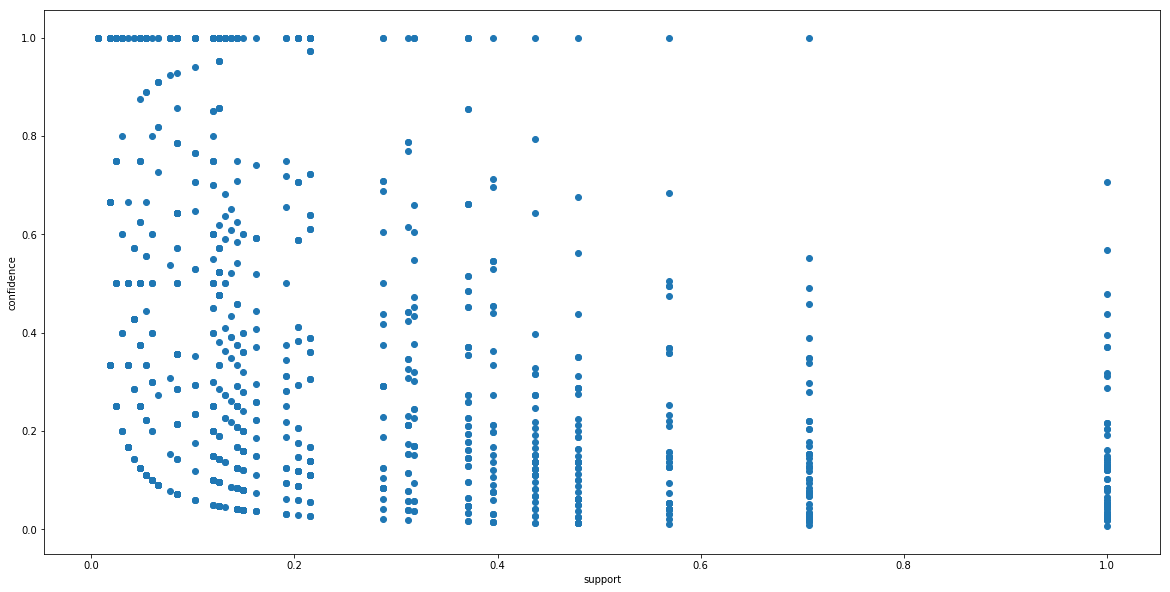

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.xlabel('support')
plt.ylabel('confidence')
plt.scatter(x, y)
plt.show()

### 可以看到，存在部分支持度为1的点和置信度为1的点，通过分析可以知道支持度为1的点来源于'US'，因为在预处理环节删除了部分数据，导致'country'属性下的变量值全是'US'。将该属性忽略后进行可视化和分析

In [36]:
x1 = []
y1 = []
for i in range(10, 45):
    for item in support_all[i]:
        sb = support_all[i][item]
        for att in item:
            temp = frozenset([att])
            s = support_all[0][temp]
            x1.append(s)
            c = sb/s
            y1.append(c)

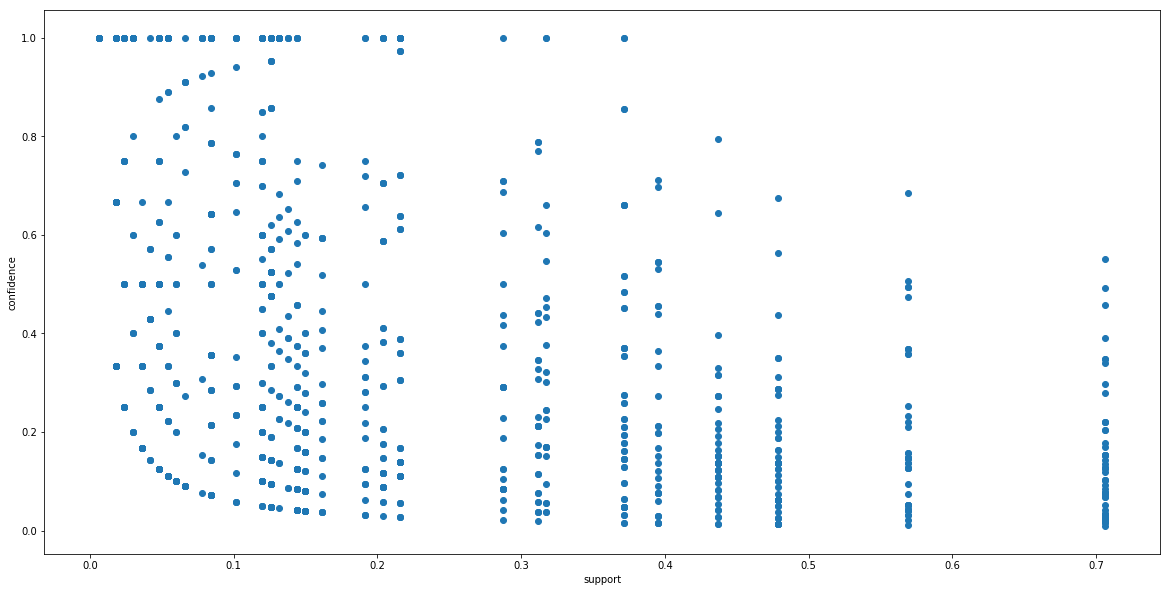

In [37]:
plt.figure(figsize=(20,10))
plt.xlabel('support')
plt.ylabel('confidence')
plt.scatter(x1, y1)
plt.show()

### 可以看到，忽略'country'属性后支持度为1的点消失不见，但仍然存在大量支持度相等，置信度不同的点。产生这种点的原因是因为将某一个值作为因变量，比如'points'属性下的'good'，其支持度固定，然后与其他联合属性计算置信度，如和联合属性'good，high'计算会产生一个置信度，和另一个属性'good, Oregon'又会产生一个置信度，所以会出现如图所示的形状

### 另外，可以看到的是，有部分点的置信度为1，对其因变量支持度大于0.2的部分进行重点观察

In [38]:
count = 0
for i in range(10, 45):
    for item in support_all[i]:
        sb = support_all[i][item]
        for att in item:
            temp = frozenset([att])
            s = support_all[0][temp]
            c = sb/s
            if c == 1 and s > 0.2:
                print(att, ' ', item, '  support:', s)
                count += 1
print('总数为:', count)

California   frozenset({'Estate', 'California'})   support: 0.2874251497005988
Sierra Foothills   frozenset({'Estate', 'Sierra Foothills'})   support: 0.20359281437125748
Sierra Foothills   frozenset({'Estate', 'Sierra Foothills'})   support: 0.20359281437125748
Willamette Valley   frozenset({'Willamette Valley', 'Oregon'})   support: 0.2155688622754491
Oregon   frozenset({'Willamette Valley', 'Oregon'})   support: 0.2155688622754491
Columbia Valley (WA)   frozenset({'Columbia Valley (WA)', 'Washington'})   support: 0.31736526946107785
Sierra Foothills   frozenset({'Sierra Foothills', 'California'})   support: 0.20359281437125748
Willamette Valley   frozenset({'Willamette Valley', 'Oregon'})   support: 0.2155688622754491
Oregon   frozenset({'Willamette Valley', 'Oregon'})   support: 0.2155688622754491
Columbia Valley   frozenset({'Columbia Valley', 'Washington'})   support: 0.3712574850299401
Washington   frozenset({'Columbia Valley', 'Washington'})   support: 0.3712574850299401
Sierra

### 出现了部分重复数据，经过分析发现是由于'region_1'和'region_2'里面有部分值完全一致，因此这里仅保留'region_1'进行可视化和观察

In [39]:
x2 = []
y2 = []
i = 10
jump = [6, 14, 21, 27, 32, 36, 40, 41, 42]
while i < 46:
    if i in jump:
        i += 1
        continue
    for item in support_all[i]:
        sb = support_all[i][item]
        for att in item:
            temp = frozenset([att])
            s = support_all[0][temp]
            x2.append(s)
            c = sb/s
            y2.append(c)
    i += 1

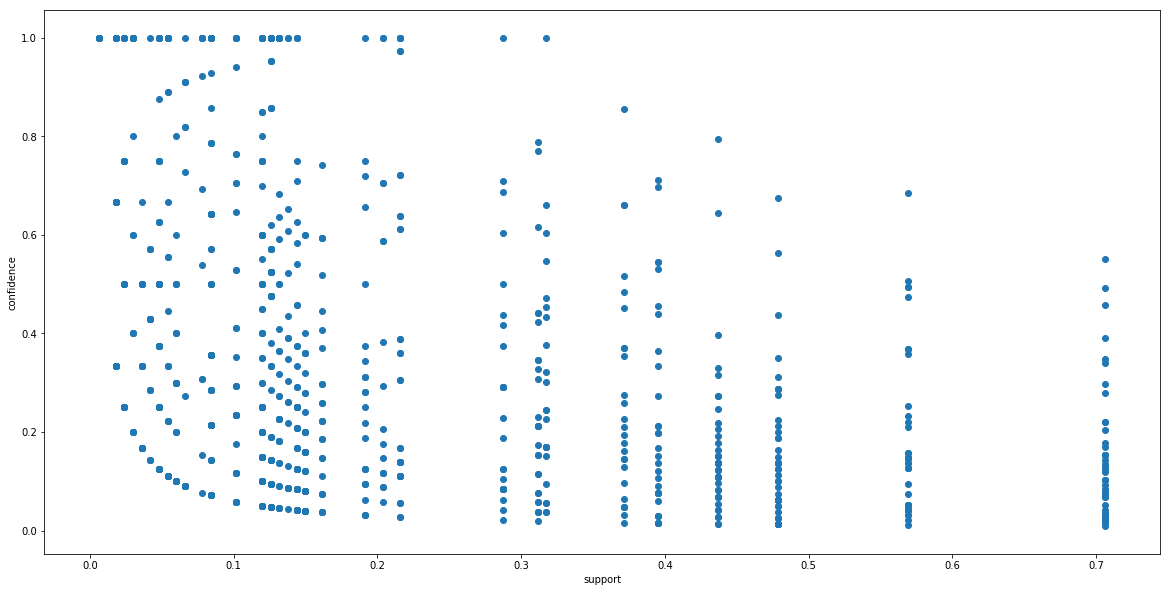

In [40]:
plt.figure(figsize=(20,10))
plt.xlabel('support')
plt.ylabel('confidence')
plt.scatter(x2, y2)
plt.show()

### 去重后图像基本没有变化，还是对置信度为1且因变量支持度大于0.2的点进行进一步分析

In [41]:
i = 10
jump = [6, 14, 21, 27, 32, 36, 40, 41, 42]
count = 0
while i < 46:
    if i in jump:
        i += 1
        continue
    for item in support_all[i]:
        sb = support_all[i][item]
        for att in item:
            temp = frozenset([att])
            s = support_all[0][temp]
            c = sb/s
            if c == 1 and s > 0.2:
                print(att, ' ', item, '  support:', s)
                count += 1
    i += 1
print('总数为： ', count)

California   frozenset({'Estate', 'California'})   support: 0.2874251497005988
Sierra Foothills   frozenset({'Estate', 'Sierra Foothills'})   support: 0.20359281437125748
Willamette Valley   frozenset({'Willamette Valley', 'Oregon'})   support: 0.2155688622754491
Oregon   frozenset({'Willamette Valley', 'Oregon'})   support: 0.2155688622754491
Columbia Valley (WA)   frozenset({'Columbia Valley (WA)', 'Washington'})   support: 0.31736526946107785
Sierra Foothills   frozenset({'Sierra Foothills', 'California'})   support: 0.20359281437125748
Oregon   frozenset({'Paul Gregutt', 'Oregon'})   support: 0.2155688622754491
Willamette Valley   frozenset({'Willamette Valley', 'Paul Gregutt'})   support: 0.2155688622754491
总数为：  8


### 去重后，总数变少。可以看到，'province'为'California'时，'designation'肯定是'Estate'，即Estate是加州的御用设计师。同时，当'province'为'Oregon'时，'taster_name'肯定是'Paul Gregutt'，即Paul Gregutt是Oregon的御用品尝家。

### 还有很多有意思的地方，现将所有置信度为1的点打印出来，大家可以自行观察

### 比如第二条关联规则，可以看到，'designation'为'Dry'时，'price'一定为'low'，即设计师Dry只设计价格较低的红酒

In [42]:
i = 10
jump = [6, 14, 21, 27, 32, 36, 40, 41, 42]
count = 0
att_comb = []
s_comb = []
allitem = []
while i < 46:
    if i in jump:
        i += 1
        continue
    for item in support_all[i]:
        sb = support_all[i][item]
        for att in item:
            temp = frozenset([att])
            s = support_all[0][temp]
            c = sb/s
            if c == 1:
                print(att, ' ', item, '  support:', s)
                allitem.append([att, item])
                att_comb.append(item)
                s_comb.append(sb)
                count += 1
    i += 1
print('总数为： ', count)

highest   frozenset({'highest', 'Reserve'})   support: 0.04790419161676647
Dry   frozenset({'low', 'Dry'})   support: 0.0658682634730539
California   frozenset({'Estate', 'California'})   support: 0.2874251497005988
Estate Grown   frozenset({'Washington', 'Estate Grown'})   support: 0.05389221556886228
Santa Clara Valley   frozenset({'Estate', 'Santa Clara Valley'})   support: 0.08383233532934131
Estate Grown   frozenset({'Columbia Valley (WA)', 'Estate Grown'})   support: 0.05389221556886228
Sierra Foothills   frozenset({'Estate', 'Sierra Foothills'})   support: 0.20359281437125748
El Dorado   frozenset({'Estate', 'El Dorado'})   support: 0.08383233532934131
Horse Heaven Hills   frozenset({'Horse Heaven Hills', 'Reserve'})   support: 0.05389221556886228
Matt Kettmann   frozenset({'Estate', 'Matt Kettmann'})   support: 0.017964071856287425
Estate Grown   frozenset({'Sean P. Sullivan', 'Estate Grown'})   support: 0.05389221556886228
Jim Gordon   frozenset({'Estate', 'Jim Gordon'})   sup

### 绘制置信度为1部分的support--lift和support--X表进行观察(X表示卡方)

In [43]:
lift_list = []
x_list = []
for i in range(len(att_comb)):
    item =  list(att_comb[i])
    x, y = item[0], item[1]
    s1 = support_all[0][frozenset([x])]
    s2 = support_all[0][frozenset([y])]
    r1, r2 = val('', '', '', '', s1, s2, s_comb[i], len(data), False, False)
    lift_list.append(r1)
    x_list.append(r2)

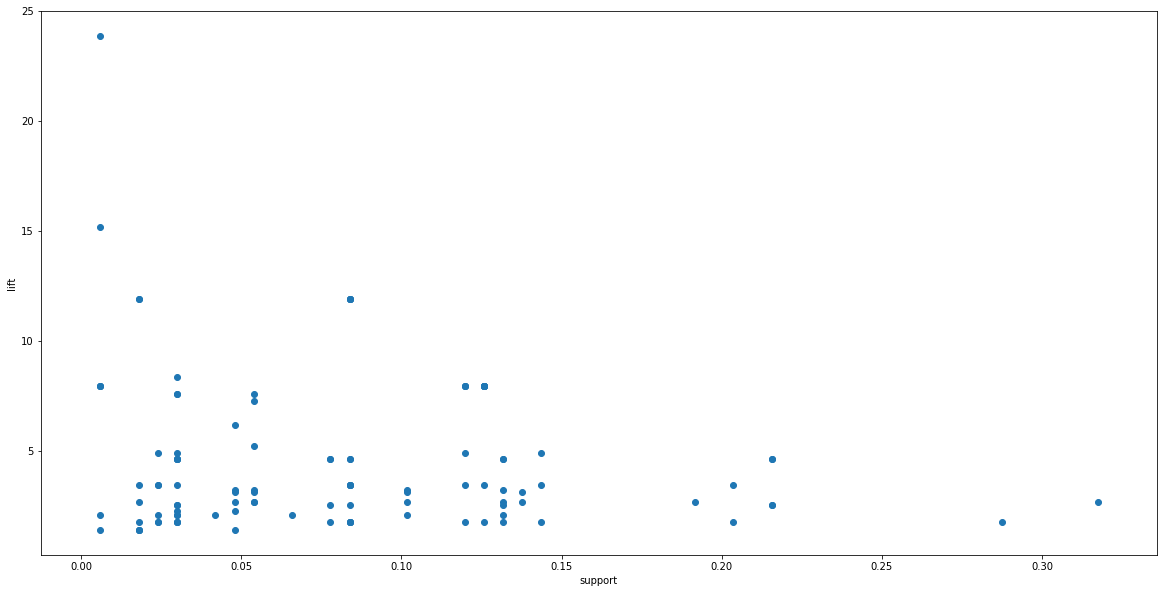

In [44]:
plt.figure(figsize=(20,10))
plt.xlabel('support')
plt.ylabel('lift')
plt.scatter(s_comb, lift_list)
plt.show()

### 左上角有一点大于20，明显的正相关，打印出来观察

In [45]:
for i in range(len(lift_list)):
    if lift_list[i] > 20:
        print(allitem[i])

['Susan Kostrzewa', frozenset({'Susan Kostrzewa', 'Rosé'})]


### 可以看到，'taster_name'的'Susan Kostrzewa'和'variety'的'Rose'有强烈的正相关，很可能是合作关系

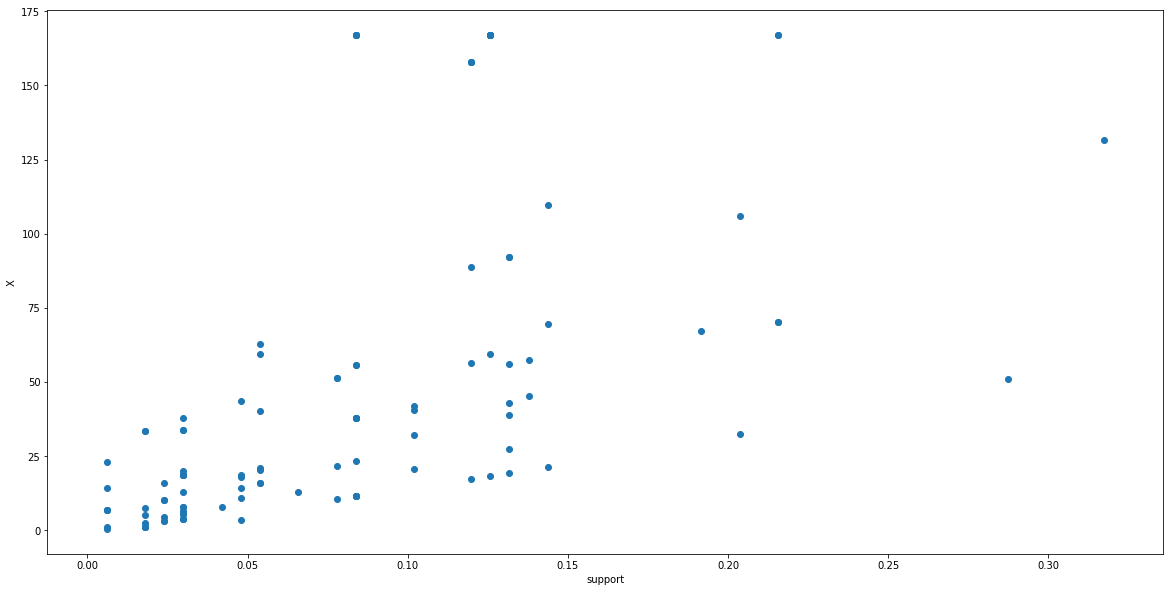

In [46]:
plt.figure(figsize=(20,10))
plt.xlabel('support')
plt.ylabel('X')
plt.scatter(s_comb, x_list)
plt.show()

### 同样的，卡方显示大多数点的值超过1，存在强烈的相关性，分析方法如上，不在此赘述